###**Pré-processamentos possiveis**:

- **Normalização**: Normalizar os pixels da imagem;
- **Conversão para escala de cinza**: Como a cor não é uma informação relevante para detecção do gesto, as imagens serão convertidas para escala de cinza;
- **Normalização de iluminação**: Diferentes imagens estao com diferentes níveis de iluminação. Dessa forma, corrigir as variaçoes de iluminação para dar destaque às mãos;
- **Realce**: aplicação de maior contraste nas cores da imagem para aprimorar o facilitar a detecção da posição dedos na frente da palma da mão. Avaliar se aplicar *realce de contraste* ou *equalização de histograma*;
- **Detecção de borda**: Detecção das bordas para mapear o formato exato da mão;
- **Remoção de fundo**: Remover o fundo da imagem para reduzir a complexidade do aprendizado pelo modelo, dada a variabilidade de cores, contraste e iluminação entre as imagens;

###**Ações:**

- **Remoçao de fundo:**Ou aplicar uma máscara e fazer a diferença entre a mascara e imagem original para remover o fundo, ou usando contornos/bordas;
- **Segmentação**: Há imagens em que o antebraço está completamente exposto, enquanto que há imagens em que o antebraço praticamente não aparece. Nesse caso, segmentar apenas a mão é importante;

###**Riscos:**

- Há imagens nas quais uma parte dos dedos são cortados, isso pode prejudicar a leitura da letra pelo modelo;
- O aparecimento do antebraço na imagem pode gerar confusões pelo modelo;

## Configuração Inicial

Configuração e import de bibliotecas, além da definição da imagem de referência.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

image_path = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/B/B55.jpg'
imagem = cv2.imread(image_path)
image_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.rcParams['axes.grid'] = False  # Desativa as grades nos plots.

## Primeiras Impressões das Imagens

Vamos plotar a imagem de referência para termos a primeira impressão, e a partir disso, realizar o pré-processamento.

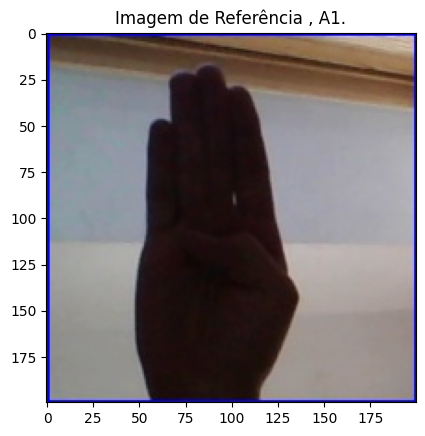

In [93]:
plt.imshow(image_rgb)
plt.title("Imagem de Referência , A1.")
plt.show()

Vamos agora, explorar as propriedades da imagem, como suas dimensões e tipo de encoding.

In [94]:
altura, largura, canais = imagem.shape

propriedades = [
    ('Altura:', altura),
    ('Largura:', largura),
    ('Canais de cor:', canais),
    ('Tipo de dado:', imagem.dtype),
    ('Desvio Padrão', imagem.std())
]

for propriedade, valor_propriedade in propriedades:
    print(f'{propriedade} {valor_propriedade}')


Altura: 200
Largura: 200
Canais de cor: 3
Tipo de dado: uint8
Desvio Padrão 65.10267886030701


Passando para os canais da imagem, vamos usar a função np.asarray(), que irá tabular a imagem em forma numérica, possibilitando a separação de canais.  
Tendo em vista cada canal separado, é possível analisar qual cor possui o maior impacto no elemento desejado da imagem, possibilitando aplicar outras operações.
Abaixo, o código para separação e representação.

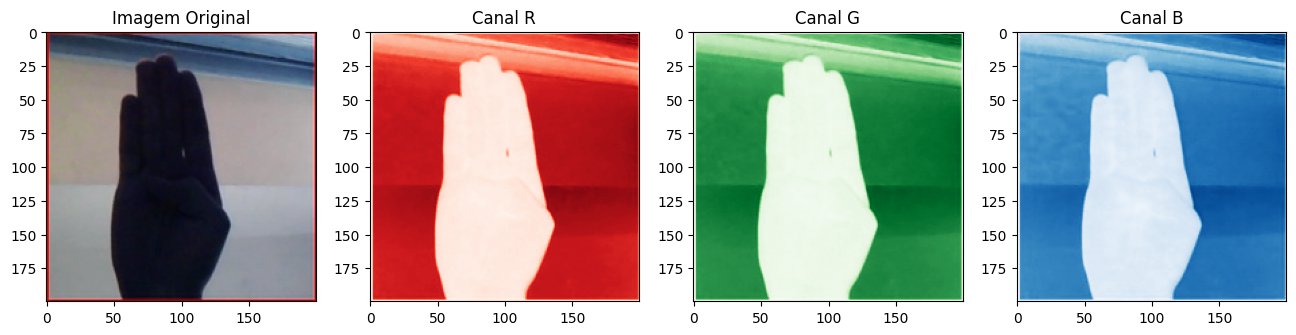

In [95]:
matriz_imagem = np.asarray(imagem)

plt.figure(figsize=(16,8))
plt.subplot(141)

plt.imshow(imagem)
plt.title("Imagem Original")
plt.subplot(142)

plt.imshow(matriz_imagem[:, :, 1], cmap="Reds")
plt.title("Canal R")
plt.subplot(143)

plt.imshow(matriz_imagem[:, :, 1], cmap="Greens")
plt.title("Canal G")
plt.subplot(144)

plt.imshow(matriz_imagem[:, :, 2], cmap="Blues")
plt.title("Canal B")
plt.show()

## Pré-processamento de Imagens

Para processamento da imagem pela rede neural, é importante a normalizaçao de seus pixels.

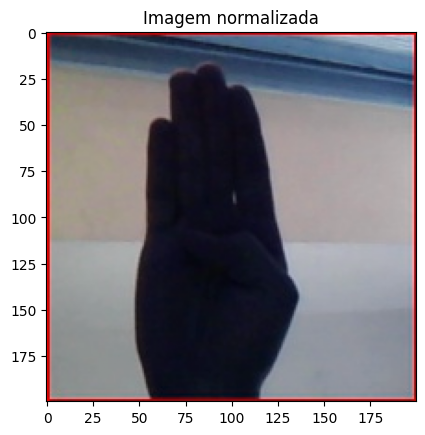

In [96]:
def norma(img):
  img_norm = img/255 # normalização dos pixels da imagem
  return img_norm

plt.imshow(norma(imagem))
plt.title("Imagem normalizada")
plt.show()

Como os gestos não são dependentes de cores para serem reconhecidos, mas sim dos formatos, vamos converter a imagem para preto e branco.  
Trabalhar com imagens na escala cinza também reduz o custo computacional para realizar processos nas imagems.

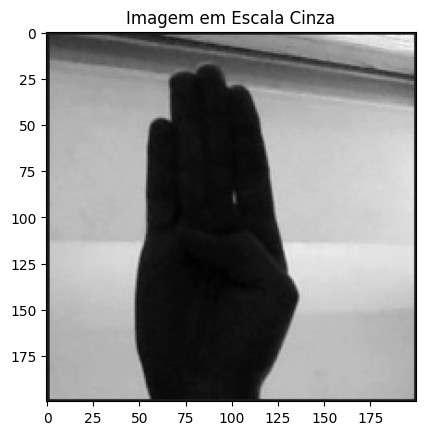

In [97]:
imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)  # Conversão para escala cinza.
plt.imshow(imagem_cinza, cmap="gray")
plt.title("Imagem em Escala Cinza")
plt.show()

Uma vez na escala de cinza, a fim de ajustar o contraste e facilitar a identificaçao das principais características da imagem, aplica-se técnicas de realce.

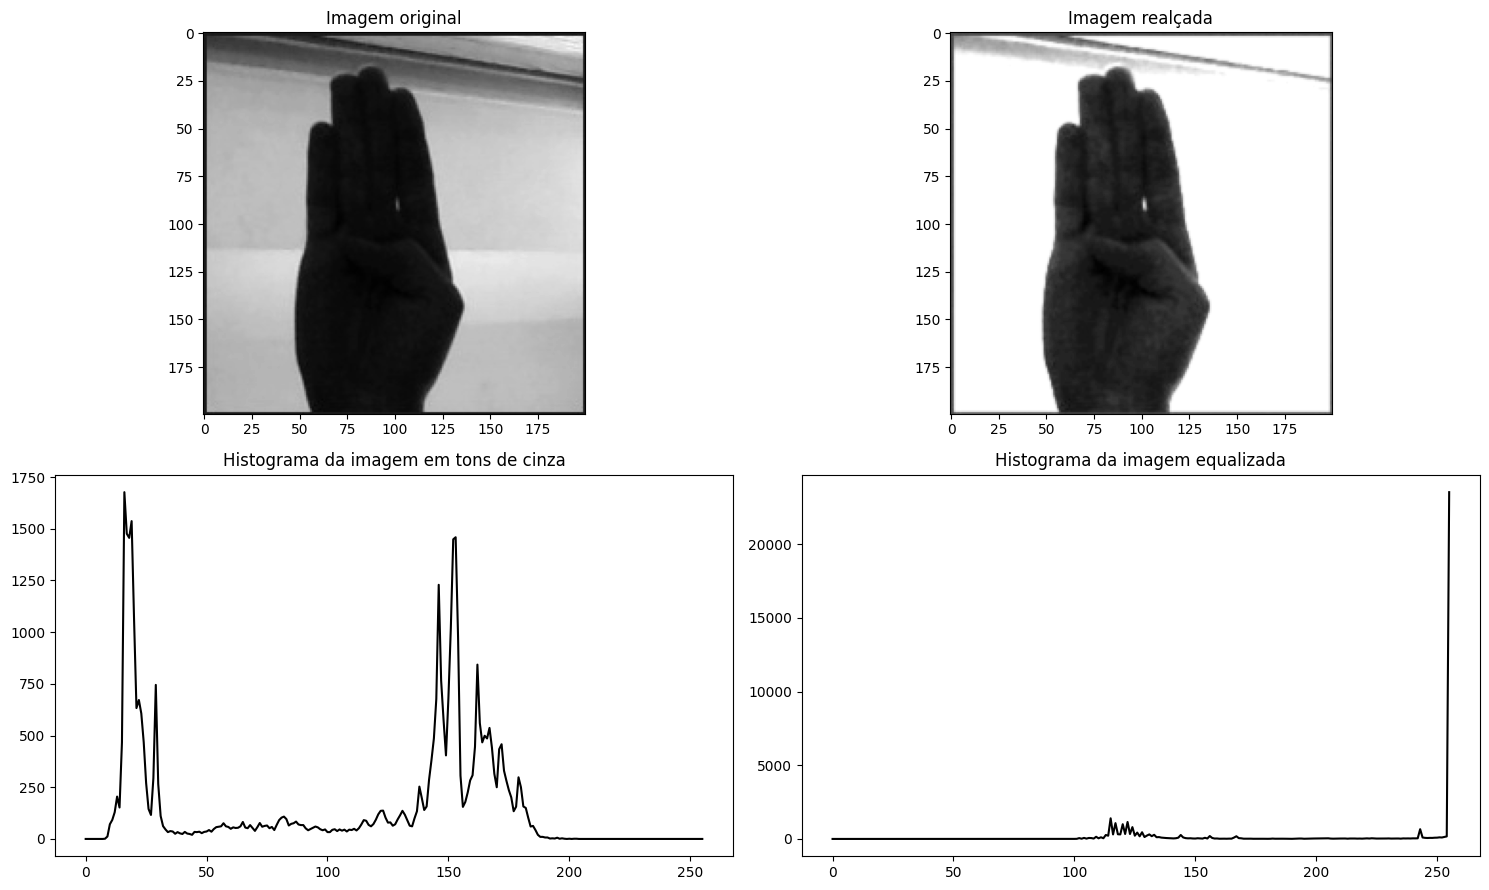

In [147]:
#img_gauss = cv2.GaussianBlur(imagem_cinza, (7,7),0)
#img_equal = cv2.equalizeHist(imagem_cinza)
img_equal = cv2.convertScaleAbs(imagem_cinza, alpha = 2.2, beta = 80)
img_equal = cv2.GaussianBlur(img_equal, (5,5), 0.5, 0.5)
hist_cinza = cv2.calcHist([imagem_cinza],[0],None,[256],[0,256])
hist_equal = cv2.calcHist([img_equal],[0],None,[256],[0,256])

plt.figure(figsize=(15,9))

plt.subplot(2,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title("Imagem original")

plt.subplot(2,2,2)
plt.imshow(img_equal, cmap='gray')
plt.title("Imagem realçada")

plt.subplot(2,2,3)
plt.plot(hist_cinza, color='black')
plt.title('Histograma da imagem em tons de cinza')

plt.subplot(2,2,4)
plt.plot(hist_equal, color='black')
plt.title('Histograma da imagem equalizada')

plt.tight_layout()
plt.show()

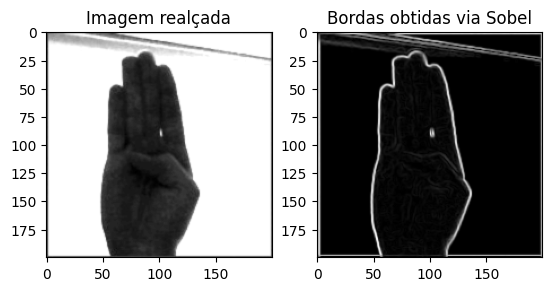

In [148]:
sobel_x = cv2.Sobel(img_equal, cv2.CV_64F, 1, 0, ksize=3, scale = 1, delta = 0)
sobel_y = cv2.Sobel(img_equal, cv2.CV_64F, 0, 1, ksize=3, scale = 1, delta = 0)

gradient_mag = np.sqrt(sobel_x**2 + sobel_y**2)

plt.subplot(1,2,1)
plt.imshow(img_equal, cmap='gray')
plt.title('Imagem realçada')
plt.subplot(1,2,2)
plt.imshow(gradient_mag, cmap='gray')
plt.title('Bordas obtidas via Sobel')

plt.show()

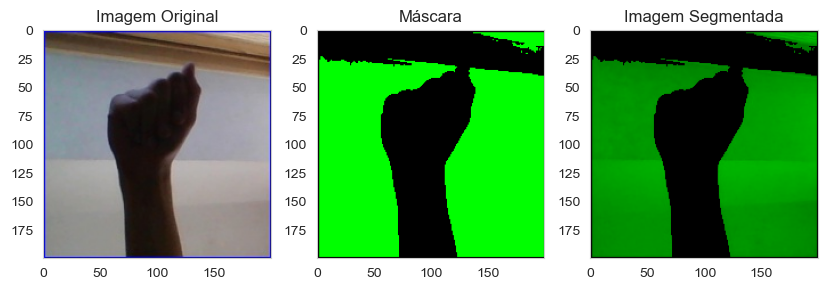

In [ ]:
gray_image = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(imagem)
cv2.drawContours(mask, contours, -1, (0, 255, 0), -1)
segmented_image = cv2.bitwise_and(imagem, mask)

plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(imagem[:, :, ::-1]), plt.title('Imagem Original')
plt.subplot(132), plt.imshow(mask[:, :, ::-1]), plt.title('Máscara')
plt.subplot(133), plt.imshow(segmented_image[:, :, ::-1]), plt.title('Imagem Segmentada')
plt.show()